Number of records in the dataset: 106
Label distribution in the dataset:
is_phishing
1    55
0    51
Name: count, dtype: int64
Training set: 84, Validation set: 11, Test set: 11
Training label distribution:
is_phishing
1    44
0    40
Name: count, dtype: int64
Validation label distribution:
is_phishing
1    6
0    5
Name: count, dtype: int64
Test label distribution:
is_phishing
0    6
1    5
Name: count, dtype: int64
Class Imbalance Ratio (0/1): 0.91
Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\krenn\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:30:28] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 0.7, 'scale_pos_weight': 0.9090909090909091, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}
Validation Metrics - XGBoost:
Accuracy: 0.7273
Precision: 0.8000
Recall: 0.6667
F1-Score: 0.7273
Log-Loss: 0.6021

Test Metrics - XGBoost:
Accuracy: 0.8182
Precision: 0.8000
Recall: 0.8000
F1-Score: 0.8000
Log-Loss: 0.4310


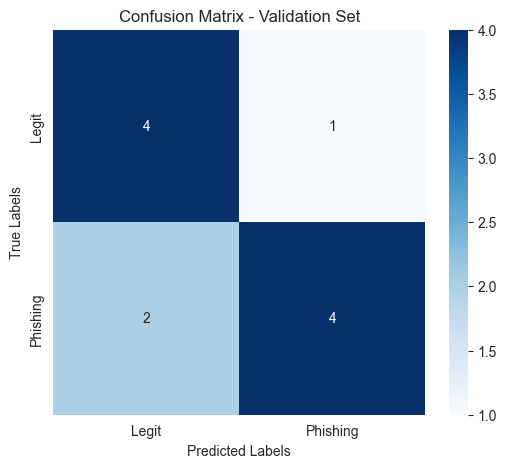

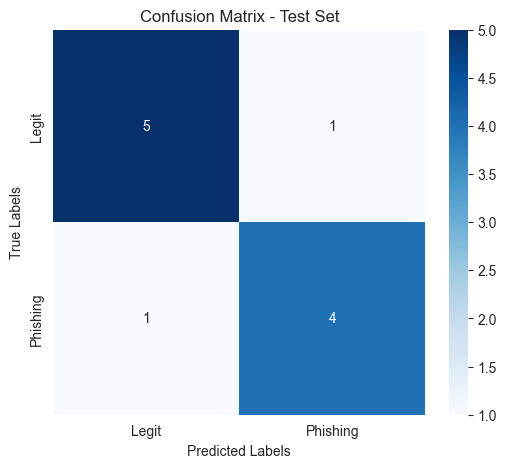

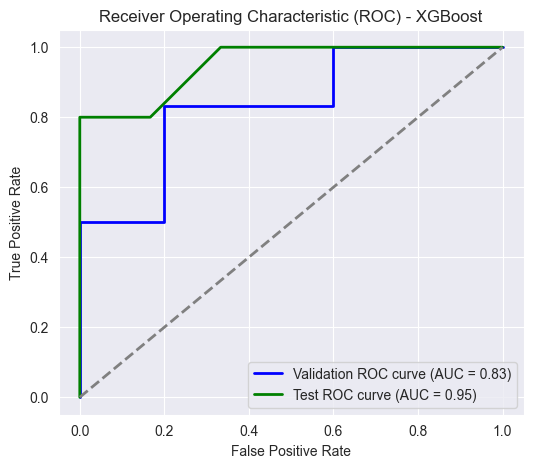

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import numpy as np

# Load dataset.
data = pd.read_csv(r'C:\Users\krenn\PycharmProjects\Phishing_DetectionRF_XGBoost\datasets_phishing\Deduplicated_Sorted_Dataset.csv', delimiter=';')

# Debugging: Number of data points in the dataset
print(f"Number of records in the dataset: {data.shape[0]}")
print(f"Label distribution in the dataset:\n{data['is_phishing'].value_counts()}")

# Split into training, validation, and test sets
train, temp = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_phishing'])
val, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['is_phishing'])

# Debugging: Check dataset sizes
print(f"Training set: {len(train)}, Validation set: {len(val)}, Test set: {len(test)}")
print(f"Training label distribution:\n{train['is_phishing'].value_counts()}")
print(f"Validation label distribution:\n{val['is_phishing'].value_counts()}")
print(f"Test label distribution:\n{test['is_phishing'].value_counts()}")

# Split data into features (X) and target (y)
X_train = train.drop(columns=['is_phishing', 'url'])
y_train = train['is_phishing']
X_val = val.drop(columns=['is_phishing', 'url'])
y_val = val['is_phishing']
X_test = test.drop(columns=['is_phishing', 'url'])
y_test = test['is_phishing']

# Compute class imbalance ratio
class_imbalance = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Class Imbalance Ratio (0/1): {class_imbalance:.2f}")

# Hyperparameter tuning for XGBoost with RandomizedSearchCV
param_dist = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [class_imbalance],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7]
}

xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, scoring='f1', cv=cv, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_xgb_model = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predictions for validation and test sets
y_val_pred_xgb = best_xgb_model.predict(X_val)
y_val_proba_xgb = best_xgb_model.predict_proba(X_val)[:, 1]
y_test_pred_xgb = best_xgb_model.predict(X_test)
y_test_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Metrics for validation set
val_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_xgb),
    "Precision": precision_score(y_val, y_val_pred_xgb),
    "Recall": recall_score(y_val, y_val_pred_xgb),
    "F1-Score": f1_score(y_val, y_val_pred_xgb),
    "Log-Loss": log_loss(y_val, y_val_proba_xgb)
}

# Metrics for test set
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred_xgb),
    "Precision": precision_score(y_test, y_test_pred_xgb),
    "Recall": recall_score(y_test, y_test_pred_xgb),
    "F1-Score": f1_score(y_test, y_test_pred_xgb),
    "Log-Loss": log_loss(y_test, y_test_proba_xgb)
}

# Print metrics
print("Validation Metrics - XGBoost:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTest Metrics - XGBoost:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix for Validation and Test Sets
cm_val = confusion_matrix(y_val, y_val_pred_xgb)
cm_test = confusion_matrix(y_test, y_test_pred_xgb)

# Define a function to plot Confusion Matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot Confusion Matrix for Validation Set
plot_confusion_matrix(cm_val, labels=['Legit', 'Phishing'], title='Confusion Matrix - Validation Set')

# Plot Confusion Matrix for Test Set
plot_confusion_matrix(cm_test, labels=['Legit', 'Phishing'], title='Confusion Matrix - Test Set')

# ROC and AUC for validation and test sets
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba_xgb)
auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_xgb)
auc_test = auc(fpr_test, tpr_test)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr_val, tpr_val, color='blue', lw=2, label=f'Validation ROC curve (AUC = {auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC curve (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - XGBoost')
plt.legend(loc='lower right')
plt.show()
